In [1]:
import pandas as pd
import numpy as np
import re
import ephem # astronomy module to get the constellations for zodiac sign
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('IDS.csv')
df.head()

,#,Gender,Height,Weight,DOB,Age,Sun_Sign,CGPA,Programming_Rate,Preferred_Lang,Sim_Course,Focus,DS_Same_As_DA,Mean,Median,Sleeping_Time,Sleep_Duration,Like_Maths,Engg_First_Choice,Inst_Choice,Physical_Activity
0,1,Female,5'3,74,7/30/2000,19.0,Aquarius,8.29,3,C++,No,Data,No,6.0,8,11:00:00 PM,5,Yes,Yes,Doesn't matter,On daily basis
1,2,Male,176,62,6/4/2000,19.0,Gemini,8.27,4,C,No,Data,May be,6.0,9,1:00:00 AM,6.5,No,Yes,Doesn't matter,Once in a week
2,3,Male,176,62,6/4/2000,19.0,Gemini,8.27,4,C,No,Data,May be,6.0,9,1:00:00 AM,6.5,No,Yes,Doesn't matter,Once in a week
3,4,Female,145,60,2/21/2000,18.0,Don't Know,9.21,3,Python,No,Data,No,6.0,9,11:00:00 AM,6,Yes,Yes,Doesn't matter,Once in a week
4,5,Male,185,56,8/15/2000,19.0,Leo,8.46,4,C,No,Data,No,6.0,8,11:30:00 PM,8,Yes,Yes,Doesn't matter,Once in a week


In [3]:
# initial visual inspection (~300 obseravtions, not too much)
"""for row in df.iterrows():
    print(row[1])"""

'for row in df.iterrows():\n    print(row[1])'

In [4]:
df.shape

(310, 21)

# Cleaning Gender

In [5]:
# Gender feature is OK
df.Gender.value_counts()

Male      222
Female     88
Name: Gender, dtype: int64

# Cleaning Height

In [6]:
# pd.to_numeric didn't quite work so:

# isolate cases with "," and '.' and replace them with "." else convert to numeric
df.Height = [i[:1]+"."+i[2] if not i.isnumeric() else i for i in df['Height']]
# convert string objects to numeric values floats since the first operation
# requrired leaving hright in feet
df.Height = pd.to_numeric(df.Height, errors='coerce',downcast='float')
# convert feet to inches
df.Height = [i*30.48 if i<100 else i for i in df['Height']]
# drop the incorrect values (too short)
df = df[df.Height > 100]
# drop height values below 100cm
df.Height = [int(i) for i in df.Height]

df.reset_index(drop=True, inplace=True)

# Cleaning Weight

In [7]:
# cutting string to only contain digits while leaving floats as they are
weight = [i if type(i) == float else i[:2] for i in df.Weight]
# converting type to numeric
df.Weight = pd.to_numeric(weight, errors='coerce', downcast='integer')
# too few nans, since there is no great variation in values 
#'backfill' is used
df.Weight.fillna(method='backfill',inplace=True)
# There is no need in containing floats as there are no values after decimals
df.Weight = [int(i) for i in df.Weight]

df.reset_index(drop=True, inplace=True)

# Cleaning DOB

In [8]:
df.DOB = pd.to_datetime(df.DOB)

# Cleaning Age

In [9]:
# it looks like the age is recorder in 2019 since those who were born in
# 2000 are all 19.

# there are 2 nan values, it's an arbitrary decision but I decided to 
# update the age using the cuurent dat while I was completing this 
# assignment
df.Age.isna().value_counts()

False    276
True       2
Name: Age, dtype: int64

In [10]:
now = pd.to_datetime('now')
df.Age = (now - df['DOB']).astype('<m8[Y]') 
df.Age.value_counts()
# it looks like some folks are too young to be on this database,
# dropping anyone who is younger than 10
df = df[df.Age > 10]
# converting age to integers
df.Age = [int(i) for i in df.Age]
df.Age.value_counts()
df.reset_index(drop=True, inplace=True)

# Cleaning Sun_Sign

In [11]:
# there are 10 "Don't Know values", astronomical module ephen was used to
# return the constallation through which the Sun was passing on 
# the day of birth. This sollution is suboptimal as there is a mismatch
# between the constellations and the signs used in Astology:
#https://en.wikipedia.org/wiki/Zodiac#Table_of_dates
# There is an additional issue since it seems to be there are actually 13
# constellations and not 12.

# the next step here is to fix the mismatching, although it will actually
# be detremental to the iintegrity of calculations

# my alternative idea was to use a dictionary with dateranges but 
# looks like it's a very tricky thing to use date ranges as key values 
# of a dict.

df.Sun_Sign.value_counts()

Scorpio        27
Virgo          26
Capricorn      24
Gemini         22
Aquarius       22
Leo            21
Aries          20
Libra          20
Cancer         19
Sagittarius    17
Pisces         16
Taurus         15
Don't Know     10
Name: Sun_Sign, dtype: int64

In [12]:
def zodiac_sign(date):
    """Returns the constellation through which the Sun was passing
    for a given date."""
    sun = ephem.Sun()
    sun.compute(date)
    return(ephem.constellation(sun)[1])


df.Sun_Sign = df.DOB.apply(zodiac_sign)
df.reset_index(drop=True, inplace=True)
df.Sun_Sign.value_counts()

Taurus         33
Virgo          32
Leo            28
Pisces         27
Gemini         26
Sagittarius    23
Capricornus    18
Cancer         16
Aquarius       15
Libra          13
Scorpius       10
Aries           9
Ophiuchus       9
Name: Sun_Sign, dtype: int64

# Cleaning CGPA

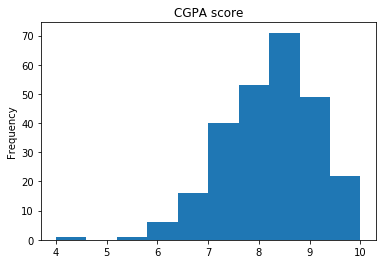

In [13]:
# The minimal reading for CGPA is being 4.0, it's suspicious  
# because it's an outlier and because it has no decimal points
# so it is replaced with the mode value.

df.CGPA.plot.hist()
plt.title('CGPA score')
plt.show()

In [14]:
df[df.CGPA < 5] =  int(df.CGPA.mode())
df.reset_index(drop=True, inplace=True)

# Cleaning Programming_Rate

In [15]:
df.Programming_Rate.describe()

count    259.000000
mean       3.173745
std        0.856307
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: Programming_Rate, dtype: float64

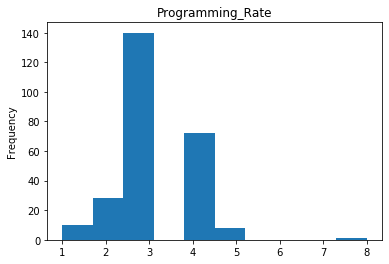

In [16]:
df.Programming_Rate.plot.hist()
plt.title("Programming_Rate")
plt.show()

In [17]:
# it looks like there are 2 distinct kinds of programmers
# the range of Programming_Rate for the 1st group is between 1 and 3
# while the second group is centered around 4 and 5.
# 8 is clearly an oulier here, so I am dropping this obseravtion.
# it also turned to be a bad raw as ALL the values for all the features 
# are 8.
df.Programming_Rate.value_counts()

3    140
4     72
2     28
1     10
5      8
8      1
Name: Programming_Rate, dtype: int64

In [18]:
df.reset_index(drop=True, inplace=True)
df[df['Programming_Rate']>7]
df.reset_index(drop=True, inplace=True)

In [19]:
df = df[df['Programming_Rate']<7]
df.reset_index(drop=True, inplace=True)

# Cleaning Preferred_Lang

In [20]:
# no cleaning required
df.Preferred_Lang.value_counts()

C         112
Python     96
C++        39
Java       10
R           1
Name: Preferred_Lang, dtype: int64

# Cleaning Sim_Course

In [21]:
# no cleaning required
df.Sim_Course.value_counts()

No     200
Yes     58
Name: Sim_Course, dtype: int64

# Cleaning 'Focus'

In [22]:
# no cleaning required
df.Focus.value_counts()

Data       202
Science     56
Name: Focus, dtype: int64

# Cleaning DS_Same_As_DA

In [23]:
# Changing 'May be' to 'Maybe'
df.DS_Same_As_DA.value_counts()

May be    135
No        113
Yes        10
Name: DS_Same_As_DA, dtype: int64

In [24]:
df.DS_Same_As_DA.replace('May be','Maybe', inplace=True)

# Cleaning Mean

In [ ]:
# There are 2 outliers wuith values equal 30. It's not clear what the 
# feature Mean represents, so I'm keeping it as it is.
#for i in df['Mean']:
#    print(i)

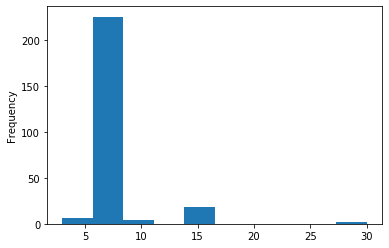

In [26]:
df['Mean'].plot.hist()
plt.show()

In [27]:
df['Mean'].value_counts()

6.0     221
15.0     18
8.0       3
5.0       2
3.0       2
30.0      2
9.0       2
5.6       1
11.0      1
4.0       1
7.5       1
10.0      1
Name: Mean, dtype: int64

In [28]:
df[df['Mean']>29]

,#,Gender,Height,Weight,DOB,Age,Sun_Sign,CGPA,Programming_Rate,Preferred_Lang,Sim_Course,Focus,DS_Same_As_DA,Mean,Median,Sleeping_Time,Sleep_Duration,Like_Maths,Engg_First_Choice,Inst_Choice,Physical_Activity
34,39,Male,156,84,2000-06-12 00:00:00,19,Taurus,9.21,3,C++,No,Data,No,30.0,9,11:00:00 PM,7,Yes,Yes,Doesn't matter,Once in a week
54,61,Male,178,62,2000-10-26 00:00:00,19,Virgo,8.75,4,Python,Yes,Data,No,30.0,8,12:30:00 AM,5 and a half hours,Yes,Yes,Doesn't matter,Not so often


In [29]:
df.columns

Index(['#', 'Gender', 'Height', 'Weight', 'DOB', 'Age', 'Sun_Sign', 'CGPA',
       'Programming_Rate', 'Preferred_Lang', 'Sim_Course', 'Focus',
       'DS_Same_As_DA', 'Mean', 'Median', 'Sleeping_Time', 'Sleep_Duration',
       'Like_Maths', 'Engg_First_Choice', 'Inst_Choice', 'Physical_Activity'],
      dtype='object')

# Cleaning Median

In [ ]:
#for i in df['Median']:
#    print(i)

In [31]:
# All the values are strings and 2 of them are not numeric,
# first the data is converted to numeric type
# then the exceptions are ffilled.
# There are no decimal values so the values are converted to int.
df.Median.value_counts()

8                                                      194
9                                                       50
5.5                                                      3
6                                                        3
5                                                        3
30                                                       1
8.5                                                      1
I                                                        1
Data has to be orderely placed to calculate median       1
4                                                        1
Name: Median, dtype: int64

In [32]:
pd.to_numeric(df.Median, errors='coerce').isna().value_counts()

False    256
True       2
Name: Median, dtype: int64

In [33]:
Median = pd.to_numeric(df.Median, errors='coerce')

In [34]:
Median.fillna(method='ffill',inplace=True,downcast='int')
df.Median = Median

df.Median = [int(i) for i in df.Median]


In [35]:
print('The median value for df.Median is:',df.Median.median())

The median value for df.Median is: 8.0


# Cleaning Sleeping_Time

In [ ]:
# So far this is the worst column.
# There are too many 'corner cases' I haven't been able to find a unified
# solution except for going through the cases one by one starting from 
# the most common ones.
# I think using re module can be of great use here. But I only used it once
# since the amount of patterns that have to be checked for is too diverse.
# I hate myself for doing it all by hand.
#for i in df.Sleeping_Time:
#    print(i)

In [39]:
sleeping_time = [i[:2] for i in df.Sleeping_Time.apply
                 (lambda x: re.findall('\d+',x))]

In [40]:
def sleeping_time_digits():
    series = []
    for i in sleeping_time:
        if len(i)==1:
            series.append(str(i[0]))
        elif len(i)==2:
            series.append(str(i[0])+str(i[1]))
    return series
            

In [41]:
sleeping_time_series = sleeping_time_digits()

In [42]:
sleeping_time_series = [i[:2]+':'+i[2:] if len(i)==4 else i for i in sleeping_time_series]

In [43]:
sleeping_time_series = pd.Series(sleeping_time_series)

In [44]:
sleeping_time_series = ['23'+i[2:] if i[:2]=='11' else i for i in sleeping_time_series]

In [45]:
sleeping_time_series = ['00'+i[2:] if i[:2]=='12' else i for i in sleeping_time_series]

In [46]:
sleeping_time_series = ['00:00' if i=='00' else i for i in sleeping_time_series]

In [47]:
sleeping_time_series = ['23:00' if i=='23' else i for i in sleeping_time_series]

In [48]:
sleeping_time_series = ['02:00' if i=='200' else i for i in sleeping_time_series]

In [49]:
sleeping_time_series = ['22:00' if i=='10:00' else i for i in sleeping_time_series]

In [50]:
sleeping_time_series = ['01:00' if i=='100' else i for i in sleeping_time_series]

In [51]:
sleeping_time_series = ['01:30' if i=='130' else i for i in sleeping_time_series]

In [52]:
sleeping_time_series = ['01:00' if i=='10' else i for i in sleeping_time_series]

In [53]:
sleeping_time_series = ['01:00' if i=='1' else i for i in sleeping_time_series]

In [54]:
sleeping_time_series = ['23:30' if i=='233' else i for i in sleeping_time_series]

In [55]:
sleeping_time_series = ['03:00' if i=='3' else i for i in sleeping_time_series]

In [56]:
sleeping_time_series = ['00:15' if i=='015' else i for i in sleeping_time_series]

In [57]:
sleeping_time_series = ['02:00' if i=='2' else i for i in sleeping_time_series]

In [58]:
sleeping_time_series = ['21:00' if i=='900' else i for i in sleeping_time_series]

In [59]:
sleeping_time_series = ['21:00' if i=='9' else i for i in sleeping_time_series]

In [60]:
sleeping_time_series = ['06:00' if i=='600' else i for i in sleeping_time_series]

In [61]:
sleeping_time_series = ['21:30' if i=='930' else i for i in sleeping_time_series]

In [62]:
sleeping_time_series = ['20:00' if i=='800' else i for i in sleeping_time_series]

In [63]:
sleeping_time_series = ['05:45' if i=='545' else i for i in sleeping_time_series]

In [64]:
sleeping_time_series = pd.Series(sleeping_time_series)
sleeping_time_series.value_counts()

23:00    91
00:00    38
23:30    33
01:00    24
22:00    14
10:30    14
00:30    12
02:00     9
01:30     5
21:00     3
23:45     3
03:00     2
22:30     1
23:29     1
21:30     1
10:45     1
20:00     1
05:45     1
06:00     1
00:15     1
dtype: int64

In [65]:
sleeping_time_series_edited = pd.DataFrame(sleeping_time_series)

In [66]:
sleeping_time_series_original = pd.DataFrame(df.Sleeping_Time)

In [67]:
sleeping_time = sleeping_time_series_original.join(sleeping_time_series_edited)

In [68]:
sleeping_time.columns = ['drop', 'Sleeping_Time']

In [69]:
df.Sleeping_Time = sleeping_time.Sleeping_Time

In [70]:
# filling nans with the most frequently observed slaaping time
df.Sleeping_Time.fillna('23:00', inplace=True)

In [71]:
df.Sleeping_Time = pd.to_datetime(df.Sleeping_Time)

In [72]:
df.Sleeping_Time =  df['Sleeping_Time'].dt.hour

In [73]:
#50% of the folks go to bed at 11 pm with 12am being the next
# most popular time.
df.Sleeping_Time.value_counts(normalize=True)*100

23    50.387597
0     19.767442
1     11.240310
22     5.813953
10     5.813953
2      3.488372
21     1.550388
3      0.775194
20     0.387597
6      0.387597
5      0.387597
Name: Sleeping_Time, dtype: float64

# Cleaning Sleep_Duration

In [74]:
df['Sleep_Duration'].value_counts()

7                     102
6                      49
8                      33
5                      17
6-7                     9
4                       6
6.5                     6
5-6                     4
10                      3
4 hours                 2
7hrs                    2
6-7 hours               1
9-10 Hrs                1
6.783762877             1
May be 6                1
8-9                     1
5 and a half hours      1
8hrs                    1
6 hrs                   1
8.5                     1
5-6hours                1
6:00                    1
9                       1
5.5hrs                  1
7 and a half            1
6hr                     1
7-8                     1
5 nd a half             1
6 hours                 1
6.75                    1
4 - 5 hrs               1
6-7                     1
Around 8 hours          1
8 hours                 1
5 and a 1/2             1
Name: Sleep_Duration, dtype: int64

In [75]:
# making sure all entries are strings
df.Sleep_Duration = df.Sleep_Duration.apply(lambda x: str(x))

In [76]:
# durations are not incorporated, it's not reasonable since
# most of the values are just descrete numbers
duration = [i for i in df.Sleep_Duration.apply
                 (lambda x: re.findall('\d+',x))]

In [77]:
duration =  pd.DataFrame(duration)[0]
# filling single None value with the most frequent
#value of 7h.
duration = duration.fillna(7)
duration = pd.to_numeric(duration)

In [78]:
df['Sleep_Duration'] = duration

# Cleaning Like_Maths

In [79]:
df['Like_Maths'].value_counts()

Yes    226
No      30
Name: Like_Maths, dtype: int64

In [80]:
# There are 2 nans, I am replacing them with 'Yes'.
df['Like_Maths'].isna().value_counts()

False    256
True       2
Name: Like_Maths, dtype: int64

In [81]:
df['Like_Maths'].fillna('Yes',inplace=True)

# Cleaning Engg_First_Choice

In [82]:
df['Engg_First_Choice'].value_counts()

Yes               206
Doesn't matter     33
Not at all         19
Name: Engg_First_Choice, dtype: int64

In [83]:
# It's not clear to me what this column represents but
# there is nothing to clean but I thought that wording can be
# improved.

In [84]:
engg_dict = {'Yes':'Yes',"Doesn't matter":'Invariant',
            'Not at all':'No'}

In [85]:
df['Engg_First_Choice'] = df['Engg_First_Choice'].map(engg_dict)

# Cleaning Inst_Choice

In [86]:
df['Inst_Choice'].value_counts()

Doesn't matter    223
Female             25
Male               10
Name: Inst_Choice, dtype: int64

In [87]:
inst_dict = {'Male':'Male',"Doesn't matter":'Invariant',
            'Female':'Female'}

In [88]:
df['Inst_Choice'] = df['Inst_Choice'].map(inst_dict)

# Cleaning Physical_Activity

In [89]:
df['Physical_Activity'].value_counts()

On daily basis     109
Once in a week      78
Not so often        53
Once in a month     14
Never                4
Name: Physical_Activity, dtype: int64

In [90]:
df['Physical_Activity'].isna().value_counts()

False    258
Name: Physical_Activity, dtype: int64

In [91]:
activity_dict = {'On daily basis':'Daily',
                'Once in a week':'Weekly',
                'Once in a month':'Monthly',
                'Never':'Never',
                'Not so often':'Rarely'} 

In [93]:
df['Physical_Activity'] = df['Physical_Activity'].map(activity_dict)

In [94]:
print('Final shape of the dataframe is: '+str(df.shape))

Final shape of the dataframe is: (258, 21)
